In [128]:
import datetime
import sys
import os
import pandas as pd
import numpy as np
import telegram
from prophet import Prophet
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from tinvest import SyncClient
from telegram import Bot
sys.path.append("..")
from stats import get_assets_df_for_period

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [62]:
def split_by_dt(df: pd.DataFrame, split_dt: datetime.date = None, test_share: float = None) -> tuple:
    df = df.sort_values("dt")
    if split_dt is not None:
        return df[df.dt <= split_dt], df[df.dt > split_dt]
    elif test_share is not None:
        count = df.shape[0]
        test = df.tail(int(test_share * count))
        train = df[~df.index.isin(test.index)]
        return train, test

In [2]:
TINKOFF_OPEN_API_TOKEN = "OPEN_API_TOKEN"
TELEGRAM_BOT_TOKEN = "TELEGRAM_BOT_TOKEN"

In [3]:
bot = Bot(token=os.getenv(TELEGRAM_BOT_TOKEN))
client = SyncClient(os.getenv(TINKOFF_OPEN_API_TOKEN))
days_to_analyze = 365
date_to = datetime.datetime.now()
date_from = date_to - datetime.timedelta(days=days_to_analyze)

etfs = client.get_market_etfs()
grouped_by_dt_candles = get_assets_df_for_period(client, etfs, date_from, date_to)

100%|██████████| 113/113 [00:10<00:00, 11.15it/s]


In [105]:
grouped_by_dt_candles.groupby(["name", "figi"]).count()

currency  closed   dt
name                               figi                               
FinEx Акции американских компаний  BBG005HLSZ23       254     254  254
FinEx Акции глобального рынка      BBG00R9805F5       256     256  256
                                   BBG00R980XY3       256     256  256
FinEx Акции казахстанских компаний BBG00M8C8Y03       256     256  256
FinEx Акции китайских компаний     BBG005VKB7D7       256     256  256
...                                                   ...     ...  ...
Тинькофф Вечный портфель RUB       BBG000000001       256     256  256
Тинькофф Вечный портфель USD       BBG000000000       256     256  256
Тинькофф Еврооблигации EUR         TCS00A103TD2        42      42   42
Тинькофф Золото                    BBG222222222       256     256  256
Тинькофф Индекс IPO                TCS00A102EM7       256     256  256

[113 rows x 3 columns]

In [141]:
figi_exmaple = grouped_by_dt_candles[grouped_by_dt_candles.figi == "TCS00A102EM7"]

In [142]:
train, test = split_by_dt(figi_exmaple, test_share=0.2)

In [143]:
train = train.reset_index()
test = test.reset_index()

In [144]:
model = Prophet()
model.fit(train.rename(columns={"dt": "ds", "closed": "y"}))

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [145]:
from prophet.plot import plot_plotly, plot_components_plotly
future = model.make_future_dataframe(periods=40)
future.tail()
forecast = model.predict(future)
plot_plotly(model, forecast)

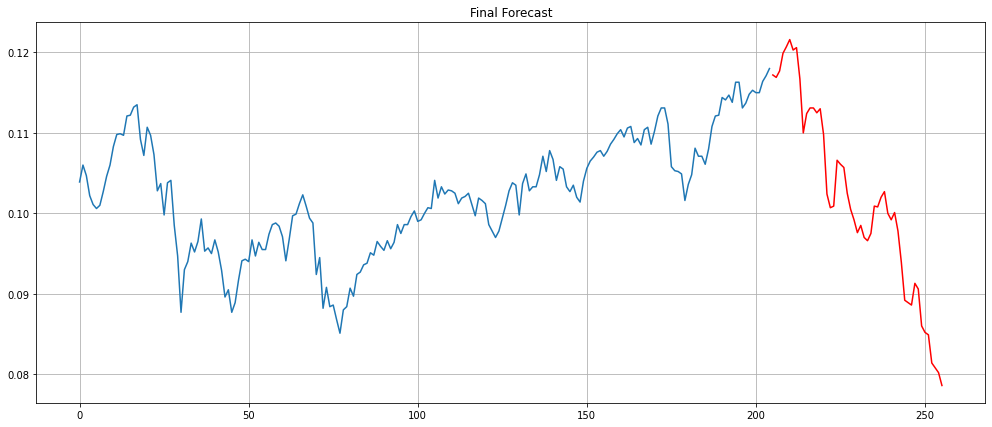

In [146]:
# Forecast
n_periods = test.shape[0]

# Plot
plt.figure(figsize=(17, 7))
plt.grid()
plt.plot(train.closed)
plt.plot(np.arange(test.shape[0]) + len(train.closed), test.closed, label="forecast", color='red')

plt.title("Final Forecast")
plt.show()